In [3]:
# ==== 0. Imports & setup ====
import os
from pathlib import Path
import sys
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Choose your base data folder (pick one option only)

# Option 1: project data root
DATA = Path("D:/LightPollutionProject/data")

# Option 2: processed folder directly
# DATA = Path("D:/LightPollutionProject/data/processed")

# Derived folders
RAW = DATA / "raw"
PROC = DATA / "processed"
PLOTS = Path("D:/LightPollutionProject/plots")

from pathlib import Path

# Define base paths (choose Option 1: recommended)
DATA = Path("D:/LightPollutionProject/data")
PROC = DATA / "processed"
PLOTS = Path("D:/LightPollutionProject/plots")




In [4]:
# Make plots directory
ROOT = Path(__file__).resolve().parents[1] if ("__file__" in globals()) else Path.cwd()
PROJ = ROOT # assume script run from project root or src/
DATA = PROJ / "data"
PLOTS = PROJ / "plots"
PROC = DATA / "processed"
PLOTS.mkdir(parents=True, exist_ok=True)
PROC.mkdir(parents=True, exist_ok=True)

In [5]:
# File candidates
SAMPLE = DATA / "asia_nightlight_sample.csv"
BIG = DATA / "VIIRS-nighttime-lights-2013m1to2024m5-level2.csv"

In [6]:
# Asia ISO list (UN style, broad)
ASIA_ISO = {
"AFG","ARM","AZE","BHR","BGD","BTN","BRN","KHM","CHN","CYP","GEO",
"IND","IDN","IRN","IRQ","ISR","JPN","JOR","KAZ","KWT","KGZ","LAO",
"LBN","MYS","MDV","MNG","MMR","NPL","PRK","OMN","PAK","PSE","PHL",
"QAT","SAU","SGP","KOR","LKA","SYR","TJK","THA","TLS","TUR","TKM",
"ARE","UZB","VNM","YEM","TWN","HKG","MAC"
}

In [10]:
# ==== 1. Data Loading ====

def read_csv_safely(path: Path, usecols=None) -> pd.DataFrame:
    """Try utf-8, then latin-1; keep numeric types; avoid memory blowups."""
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    
    encodings = ["utf-8", "utf-8-sig", "latin-1"]
    last_err = None
    
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc, low_memory=False, usecols=usecols)
            return df
        except Exception as e:
            last_err = e
    
    raise last_err


def load_asia_df() -> pd.DataFrame:
    """Load sample if present; else stream-read big CSV and filter to Asia."""
    want_cols = ["iso","id_1","name_1","id_2","name_2","year","month","nlsum","area"]

    if SAMPLE.exists():
        df = read_csv_safely(SAMPLE, usecols=None)
        # Ensure expected columns
        missing = [c for c in want_cols if c not in df.columns]
        if missing:
            raise ValueError(f"Sample CSV missing columns: {missing}")
        return df

    if BIG.exists():
        # Chunked read & filter to Asia to reduce memory
        chunks = []
        for chunk in pd.read_csv(BIG, chunksize=200_000, low_memory=False):
            if "iso" not in chunk.columns:
                raise ValueError("Expected 'iso' column in big CSV.")
            chunk = chunk.loc[chunk["iso"].astype(str).isin(ASIA_ISO)]
            # Keep only needed columns if present
            keep = [c for c in want_cols if c in chunk.columns]
            chunk = chunk[keep]
            chunks.append(chunk)
        
        if not chunks:
            raise RuntimeError("No Asia rows found in big CSV.")
        
        df = pd.concat(chunks, ignore_index=True)
        return df

    raise FileNotFoundError(
        f"Neither sample nor big CSV found. Expected at: {SAMPLE} or {BIG}"
    )


In [12]:
# ==== 2. Preprocessing ====

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Types
    for c in ("year", "month"):
        df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in ("nlsum", "area"):
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Basic cleaning
    df = df.dropna(subset=["iso", "year", "month", "nlsum", "area"]).copy()
    df = df[df["area"] > 0].copy()
    df = df[df["month"].between(1, 12)].copy()
    df["iso"] = df["iso"].astype(str).str.upper()

    # Datetime index
    df["date"] = pd.to_datetime(
        dict(year=df["year"].astype(int), month=df["month"].astype(int), day=1)
    )

    # Feature engineering: brightness per km²
    df["nl_density"] = df["nlsum"] / df["area"]

    # Outlier handling (winsorize 1%/99%) on nl_density
    lo, hi = df["nl_density"].quantile([0.01, 0.99])
    df["nl_density_clipped"] = df["nl_density"].clip(lower=lo, upper=hi)

    # Keep only Asia iso codes (safety)
    df = df[df["iso"].isin(ASIA_ISO)].copy()

    return df


In [14]:
# ==== 3. Aggregations ====

def make_aggregates(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    # Country-month average density
    monthly = (
        df.groupby(["iso", "date"], as_index=False)["nl_density_clipped"].mean()
        .rename(columns={"nl_density_clipped": "avg_density"})
    )

    # Country-year average density
    yearly = (
        df.groupby(["iso", "year"], as_index=False)["nl_density_clipped"].mean()
        .rename(columns={"nl_density_clipped": "avg_density"})
    )

    # Asia-average by year
    asia_year = (
        df.groupby("year", as_index=False)["nl_density_clipped"].mean()
        .rename(columns={"nl_density_clipped": "asia_avg_density"})
    )

    # Top districts by long-run average density
    if set(["name_2"]).issubset(df.columns):
        district_rank = (
            df.groupby(["iso", "name_2"], as_index=False)["nl_density_clipped"].mean()
            .rename(columns={"nl_density_clipped": "avg_density"})
            .sort_values("avg_density", ascending=False)
        )
    else:
        district_rank = pd.DataFrame()

    return {
        "monthly": monthly,
        "yearly": yearly,
        "asia_year": asia_year,
        "district_rank": district_rank,
    }


In [16]:
# ==== 4. Plotting helpers (Matplotlib only) ====

def plot_asia_trend(asia_year: pd.DataFrame):
    fig = plt.figure()
    plt.plot(asia_year["year"], asia_year["asia_avg_density"], marker="o")
    plt.title("Asia — Average Nightlight Density by Year")
    plt.xlabel("Year")
    plt.ylabel("Avg nightlight density (clipped)")
    _savefig(PLOTS / "asia_year_trend.png")


def plot_country_trends(yearly: pd.DataFrame, countries=("IND","CHN","JPN","IDN","PAK")):
    fig = plt.figure()
    for iso in countries:
        sub = yearly[yearly["iso"] == iso]
        if not sub.empty:
            plt.plot(sub["year"], sub["avg_density"], marker="o", label=iso)
    plt.legend()
    plt.title("Country Trends — Avg Nightlight Density by Year")
    plt.xlabel("Year")
    plt.ylabel("Avg nightlight density (clipped)")
    _savefig(PLOTS / "country_year_trends.png")


def plot_distribution(df: pd.DataFrame):
    fig = plt.figure()
    plt.hist(df["nl_density"].dropna(), bins=40)
    plt.title("Distribution of Nightlight Density")
    plt.xlabel("Nightlight density")
    plt.ylabel("Count")
    _savefig(PLOTS / "density_histogram.png")


def plot_top_districts(district_rank: pd.DataFrame, top_n=15):
    if district_rank.empty:
        return
    top = district_rank.head(top_n).iloc[::-1]  # reverse for horizontal bar
    fig = plt.figure()
    plt.barh(top["name_2"], top["avg_density"])  # default colors
    plt.title(f"Top {top_n} Districts by Avg Nightlight Density")
    plt.xlabel("Avg nightlight density (clipped)")
    plt.ylabel("District (name_2)")
    _savefig(PLOTS / "top_districts.png")


def plot_corr_heatmap(df: pd.DataFrame):
    cols = [c for c in ["nlsum","area","nl_density","nl_density_clipped"] if c in df.columns]
    if len(cols) < 2:
        return
    corr = df[cols].corr(numeric_only=True)
    fig = plt.figure()
    im = plt.imshow(corr.values, aspect="auto")
    plt.colorbar(im)
    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.yticks(range(len(cols)), cols)
    plt.title("Correlation Heatmap (numeric features)")
    _savefig(PLOTS / "correlation_heatmap.png")


In [18]:
# ==== 5. Baseline model (optional) ====

def baseline_forecast(yearly: pd.DataFrame, iso: str = "IND", horizon: int = 3):
    if LinearRegression is None:
        print("scikit-learn not available; skipping baseline forecast.")
        return
    
    sub = yearly[yearly["iso"] == iso].dropna(subset=["avg_density"])  # type: ignore
    if len(sub) < 4:
        print(f"Not enough data points to fit baseline for {iso}.")
        return
    
    X = sub[["year"]].values
    y = sub["avg_density"].values
    model = LinearRegression().fit(X, y)
    
    last_year = int(sub["year"].max())
    future_years = np.arange(last_year + 1, last_year + 1 + horizon)
    yhat = model.predict(future_years.reshape(-1, 1))

    # Plot
    fig = plt.figure()
    plt.plot(sub["year"], y, marker="o", label="Actual")
    plt.plot(future_years, yhat, marker="o", linestyle="--", label="Forecast")
    plt.title(f"Baseline Forecast ({iso}) — Avg Nightlight Density")
    plt.xlabel("Year")
    plt.ylabel("Avg nightlight density (clipped)")
    plt.legend()
    _savefig(PLOTS / f"baseline_forecast_{iso}.png")


In [26]:
# ==== 6. Main ====

def main():
    print("\n== Loading data ==")
    df = load_asia_df()
    print("Loaded:", df.shape, "columns:", list(df.columns))

    print("\n== Preprocessing ==")
    dfp = preprocess(df)
    print("After preprocess:", dfp.shape)

    # Save processed snapshot
    out_proc = PROC / "asia_nightlights_processed.csv"
    dfp.to_csv(out_proc, index=False)
    print("Saved:", out_proc)

    print("\n== Aggregations ==")
    aggs = make_aggregates(dfp)
    for name, d in aggs.items():
        if not d.empty:
            out = PROC / f"{name}.csv"
            d.to_csv(out, index=False)
            print("Saved:", out)

    print("\n== EDA Plots ==")
    if not aggs["asia_year"].empty:
        plot_asia_trend(aggs["asia_year"])  # plots/asia_year_trend.png
    if not aggs["yearly"].empty:
        plot_country_trends(aggs["yearly"])  # plots/country_year_trends.png
    plot_distribution(dfp)  # plots/density_histogram.png
    plot_corr_heatmap(dfp)  # plots/correlation_heatmap.png
    if not aggs["district_rank"].empty:
        plot_top_districts(aggs["district_rank"])  # plots/top_districts.png

    print("\n== Baseline Forecast ==")
    if not aggs["yearly"].empty:
        baseline_forecast(aggs["yearly"], iso="IND", horizon=3)

    print("\nDone. Check the 'processed' CSVs in data/processed/ and PNGs in plots/.")


if __name__ == "__main__":
    main()



== Loading data ==
Loaded: (200, 9) columns: ['iso', 'id_1', 'name_1', 'id_2', 'name_2', 'year', 'month', 'nlsum', 'area']

== Preprocessing ==
After preprocess: (200, 12)
Saved: D:\LightPollutionProject\data\processed\asia_nightlights_processed.csv

== Aggregations ==
Saved: D:\LightPollutionProject\data\processed\monthly.csv
Saved: D:\LightPollutionProject\data\processed\yearly.csv
Saved: D:\LightPollutionProject\data\processed\asia_year.csv
Saved: D:\LightPollutionProject\data\processed\district_rank.csv

== EDA Plots ==
Saved plot: D:\LightPollutionProject\plots\asia_year_trend.png


C:\Users\one\AppData\Local\Temp\ipykernel_34656\3100224981.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Saved plot: D:\LightPollutionProject\plots\country_year_trends.png
Saved plot: D:\LightPollutionProject\plots\density_histogram.png
Saved plot: D:\LightPollutionProject\plots\correlation_heatmap.png
Saved plot: D:\LightPollutionProject\plots\top_districts.png

== Baseline Forecast ==
Not enough data points to fit baseline for IND.

Done. Check the 'processed' CSVs in data/processed/ and PNGs in plots/.


In [23]:
# ---- Paths ----
DATA = Path("D:/LightPollutionProject/data")
SAMPLE = DATA / "asia_nightlight_sample.csv"
BIG = DATA / "VIIRS-nighttime-lights-2013m1to2024m5-level2.csv"
PROC = DATA / "processed"
PLOTS = Path("D:/LightPollutionProject/plots")

# Ensure output folders exist
PROC.mkdir(parents=True, exist_ok=True)
PLOTS.mkdir(parents=True, exist_ok=True)


In [25]:
def _savefig(path, dpi=150):
    """Save the current matplotlib figure into the plots/ folder."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)  # make sure folder exists
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.close()
    print(f"Saved plot: {path}")


In [27]:
import pandas as pd
from pathlib import Path

DATA = Path("D:/LightPollutionProject/data/processed")
df = pd.read_csv(DATA / "asia_year.csv")

print(df.head())


   year  asia_avg_density
0  2013          1.065663
1  2014          1.154520
2  2015          0.956228
3  2016          0.791901
4  2017          1.894944



== Forecasting with Prophet ==


20:22:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:36 - cmdstanpy - INFO - Chain [1] done processing
D:\Anaconda3\envs\lightpollution\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast: D:\LightPollutionProject\data\processed\prophet_forecast.csv
Saved forecast plot: D:\LightPollutionProject\plots\prophet_forecast.png
Saved components plot: D:\LightPollutionProject\plots\prophet_components.png


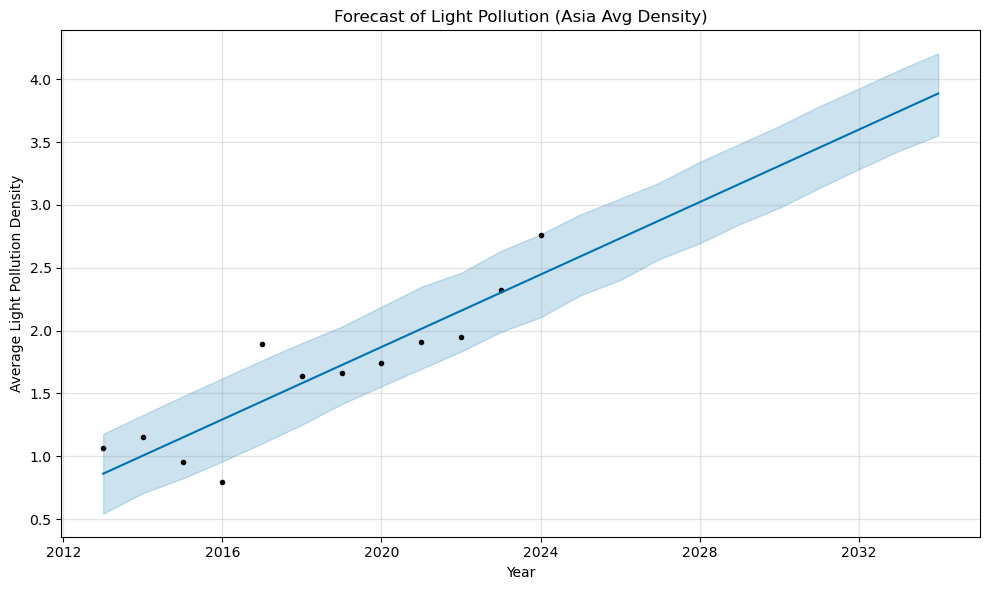

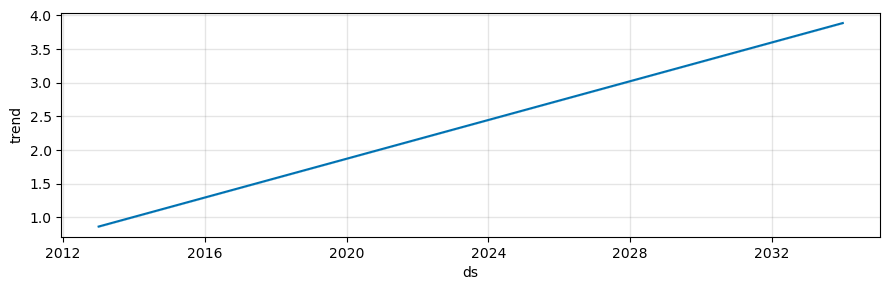

In [4]:
# ==== 6. Forecasting with Prophet ====
from prophet import Prophet

print("\n== Forecasting with Prophet ==")

# Load the yearly aggregated data
yearly_path = PROC / "asia_year.csv"

df_year = pd.read_csv(yearly_path)

# Prophet needs columns 'ds' (date/time) and 'y' (value)
df_prophet = df_year.rename(columns={"year": "ds", "asia_avg_density": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

if len(df_prophet) >= 3:  # Prophet works with very small datasets, but 3+ recommended
    # Define model
    model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_prophet)

    # Make future dataframe for next 10 years
    future = model.make_future_dataframe(periods=10, freq="Y")
    forecast = model.predict(future)

    # Save forecast results
    forecast_path = DATA / "processed" / "prophet_forecast.csv"
    forecast.to_csv(forecast_path, index=False)
    print(f"Saved forecast: {forecast_path}")

    # Plot forecast
    fig1 = model.plot(forecast)
    plt.title("Forecast of Light Pollution (Asia Avg Density)")
    plt.xlabel("Year")
    plt.ylabel("Average Light Pollution Density")
    plt.tight_layout()
    plt_path = DATA.parent / "plots" / "prophet_forecast.png"
    fig1.savefig(plt_path)
    print(f"Saved forecast plot: {plt_path}")

    # Plot components (trend, seasonality)
    fig2 = model.plot_components(forecast)
    comp_path = DATA.parent / "plots" / "prophet_components.png"
    fig2.savefig(comp_path)
    print(f"Saved components plot: {comp_path}")
else:
    print("Not enough data points for Prophet to fit reliably.")


In [5]:
df_forecast = pd.read_csv(DATA / "processed" / "prophet_forecast.csv")
print(df_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10))


            ds      yhat  yhat_lower  yhat_upper
12  2024-12-31  2.589887    2.280655    2.924516
13  2025-12-31  2.733927    2.401995    3.049900
14  2026-12-31  2.877967    2.569834    3.179037
15  2027-12-31  3.022007    2.693919    3.342613
16  2028-12-31  3.166441    2.845904    3.484679
17  2029-12-31  3.310482    2.975614    3.627393
18  2030-12-31  3.454522    3.132896    3.783713
19  2031-12-31  3.598562    3.283544    3.926058
20  2032-12-31  3.742996    3.428105    4.071239
21  2033-12-31  3.887036    3.553493    4.206397


In [6]:
train = df_prophet[df_prophet["ds"].dt.year < 2017]
test = df_prophet[df_prophet["ds"].dt.year == 2017]

model = Prophet(yearly_seasonality=False)
model.fit(train)

future = model.make_future_dataframe(periods=1, freq="Y")
forecast = model.predict(future)

print("Actual 2017:", test["y"].values[0])
print("Predicted 2017:", forecast.tail(1)["yhat"].values[0])


20:24:16 - cmdstanpy - INFO - Chain [1] start processing
20:24:16 - cmdstanpy - INFO - Chain [1] done processing
D:\Anaconda3\envs\lightpollution\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Actual 2017: 1.8949435537087296
Predicted 2017: 0.7373476230490578
